#### Implementation of InceptionResNetV2 for classification of skin lesions using the MNIST-HAM10000 Dataset.
- Date : January 23rd 2024
- Author : Aarya Bhave
- Project : Skin_Cancer_Diagnosis
  
This code carries out transfer-learning on the InceptionResNetV2 Model for classification of seven types of skin lesions.  
Before running this file locally, you must have Tensorflow-GPU installed with a dedicated GPU.
 

In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-01-25 11:58:20.669830: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 11:58:20.696610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 11:58:20.696638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 11:58:20.697338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 11:58:20.701761: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#IMPORT LIBRARIES :
import matplotlib.pyplot as plt 
import seaborn as sns
#import cv2
import numpy as np
import pandas as pd
import sklearn

##### Compute class weight for handling the skew.

In [3]:
#Load the Meta Data
meta_data = pd.read_csv('data/HAM10000_metadata.csv')
labels = meta_data['dx']

#Compute and process class weights
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(labels),
                                                 y=labels)
class_weight_dictionary = dict(enumerate(class_weights))
class_weight_dictionary

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

##### Set up ImageDataGenerator and the loader objects

In [4]:
#Setup generator.
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                               preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

data_dir = 'data/reorganized'
batch_size = 32
target_size = (224,224)

#Setup loaders.
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


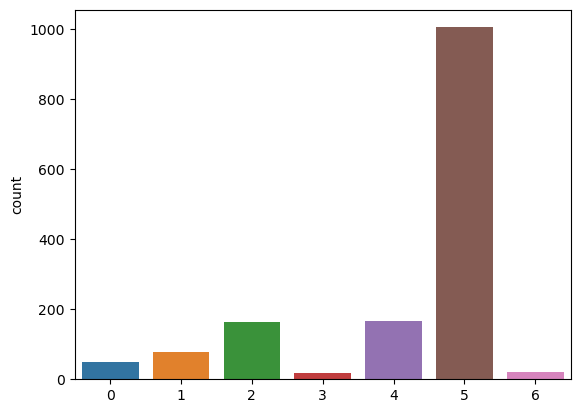

In [5]:
#Test-Set skew.
sns.countplot(x=test_image_gen.classes)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


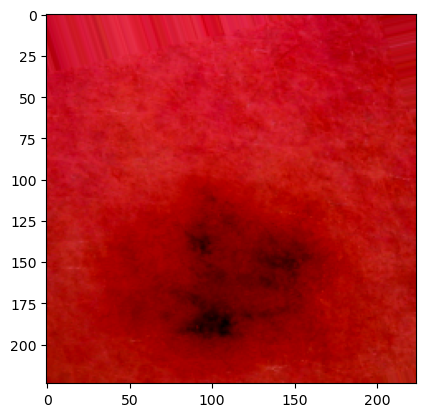

In [6]:
#Checkout a picture
plt.imshow(train_image_gen[0][0][0])
plt.show()

##### Create the trainable InceptionResNetV2 Model
- _InceptionResNetV2 Base_  

- _GlobalAveragePooling2D Layer_  
- _Regularized Dense Layer_  
- _Dropout Layer_  
- _Output Dense Layer_  

In [7]:
#Build model
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# for i in range(0, 10):
#     base_model.layers[i].trainable = False
for layer in base_model.layers:
    layer.trainable = True
# for layer in base_model.layers:
#     print(layer.name, layer.trainable)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(7, activation='softmax')(x)
incres_model = tf.keras.models.Model(inputs=base_model.input, outputs=x)


incres_model.summary()

2024-01-25 11:58:30.080616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 11:58:30.080862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 11:58:30.081003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [8]:
optimizer = tf.keras.optimizers.Adam(0.0001)
incres_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### **MODEL TRAINING**
- Train only when on a power supply.
- Use performance power mode.

In [9]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.0000001,verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = tf.keras.callbacks.ModelCheckpoint('best_model_dn121.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [12]:
history = incres_model.fit(train_image_gen,
                       epochs=15, 
                       validation_data = test_image_gen,
                       class_weight=class_weight_dictionary,
                       callbacks=callback_list)

Epoch 1/15
267/267 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9755
Epoch 1: val_accuracy did not improve from 0.89326
267/267 [==============================] - 129s 484ms/step - loss: 0.2669 - accuracy: 0.9755 - val_loss: 0.6727 - val_accuracy: 0.8819 - lr: 1.0000e-06
Epoch 2/15
267/267 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.9749
Epoch 2: val_accuracy did not improve from 0.89326
267/267 [==============================] - 125s 469ms/step - loss: 0.2734 - accuracy: 0.9749 - val_loss: 0.6890 - val_accuracy: 0.8853 - lr: 1.0000e-06
Epoch 3/15
267/267 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9766
Epoch 3: val_accuracy did not improve from 0.89326
267/267 [==============================] - 124s 464ms/step - loss: 0.2669 - accuracy: 0.9766 - val_loss: 0.6850 - val_accuracy: 0.8799 - lr: 1.0000e-06
Epoch 4/15
267/267 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.9773
Epoch 4

##### Model Evaluation

In [13]:
df=pd.DataFrame(incres_model.history.history)
df.to_csv('hist3.csv')

<Axes: >

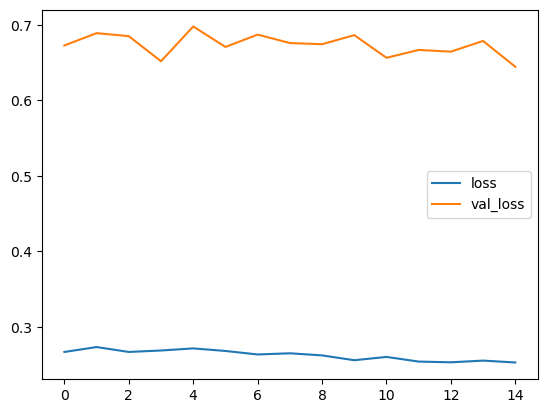

In [14]:
metrics = pd.DataFrame(incres_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

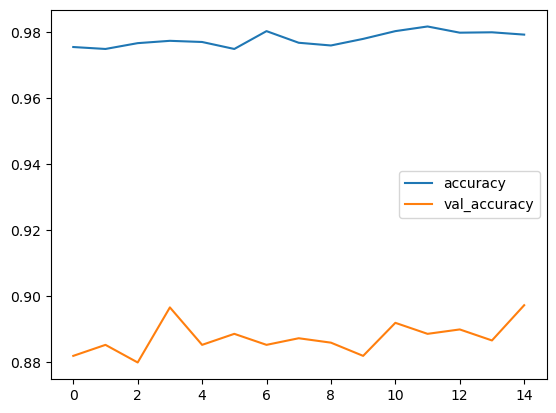

In [15]:
metrics[["accuracy","val_accuracy"]].plot()

In [16]:
predictions = incres_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

47/47 [==============================] - 25s 474ms/step


In [17]:
pred_df = pd.DataFrame({"true":test_labels, "pred":predictions})
pred_df.to_csv("pred_df.csv")

In [18]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75        49
           1       0.85      0.92      0.88        77
           2       0.78      0.76      0.77       164
           3       0.72      0.76      0.74        17
           4       0.74      0.64      0.69       166
           5       0.94      0.95      0.94      1005
           6       0.83      0.95      0.89        21

    accuracy                           0.89      1499
   macro avg       0.80      0.82      0.81      1499
weighted avg       0.88      0.89      0.88      1499



##### Plot confusion matrix

Normalized confusion matrix
[[0.7755102  0.10204082 0.08163265 0.02040816 0.02040816 0.
  0.        ]
 [0.         0.92207792 0.         0.         0.01298701 0.06493506
  0.        ]
 [0.0304878  0.00609756 0.75609756 0.01219512 0.07317073 0.12195122
  0.        ]
 [0.11764706 0.11764706 0.         0.76470588 0.         0.
  0.        ]
 [0.03012048 0.01204819 0.07228916 0.         0.63855422 0.22891566
  0.01807229]
 [0.00199005 0.00298507 0.01890547 0.00199005 0.02288557 0.95024876
  0.00099502]
 [0.         0.         0.04761905 0.         0.         0.
  0.95238095]]


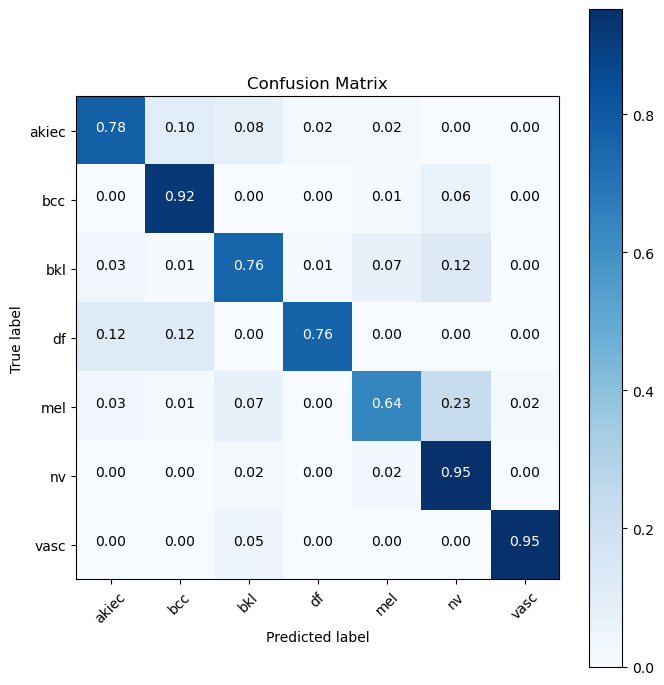

In [19]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

##### **MODEL SAVING**

In [20]:
incres_model.save("Prototyped_Models/InceptionResNetV2_standard.h5", save_format='h5')

/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(incres_model)
tflite_model = converter.convert()
open("Prototyped_Models/InceptionResNetV2_lite.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpsypu6p0m/assets


INFO:tensorflow:Assets written to: /tmp/tmpsypu6p0m/assets
2024-01-25 14:05:16.000123: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-25 14:05:16.000170: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-25 14:05:16.000612: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsypu6p0m
2024-01-25 14:05:16.077200: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-25 14:05:16.077300: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsypu6p0m
2024-01-25 14:05:16.235283: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-25 14:05:16.351603: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-25 14:05:20.390238: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

218036632

In [22]:
import tensorflowjs as tfjs 
tfjs.converters.save_keras_model(incres_model, 'Prototyped_Models/Web_Deployment')

/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
incres_model.save("InceptionResNetV2_Loadable")

INFO:tensorflow:Assets written to: InceptionResNetV2_Loadable/assets


INFO:tensorflow:Assets written to: InceptionResNetV2_Loadable/assets
